# RL con Entorno Particular

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [4]:
from gym import Env
from gym.spaces import Discrete, Box

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

In [6]:
class EntornoParticular(Env):
    def __init__(self):
        self.action_space = Discrete(3)
        self.observation_space = Box(low=np.array([0.0]), high=np.array([100.0]))
        self.state = 38 + random.randint(-3,3)
        self.shower_length = 60
        
    def step(self, action):
        self.state += action - 1
        self.shower_length -= 1
        
        #reward = (self.state >= 37 and self.state <=39)*2 - 1
        reward = (abs(self.state - 38.0) <= 1) * 2 - 1
        done = (self.shower_length <= 0)
        self.state += random.randint(-1,1)/10
        info = {}
        return self.state, reward, done, info
        
    def render(self):
        pass
    
    def reset(self):
        self.state = 38 + random.randint(-3,3)
        self.shower_length = 60
        return self.state

In [8]:
env = EntornoParticular()

C:\AnacondaD\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [10]:
t = env.reset()
print(t)
env.step(env.action_space.sample())

37


(36.9, 1, False, {})

In [12]:
for i in range(20):
    print(env.action_space.sample(), end=' ')

0 1 2 2 1 1 0 2 2 0 2 2 2 0 2 2 0 1 0 0 

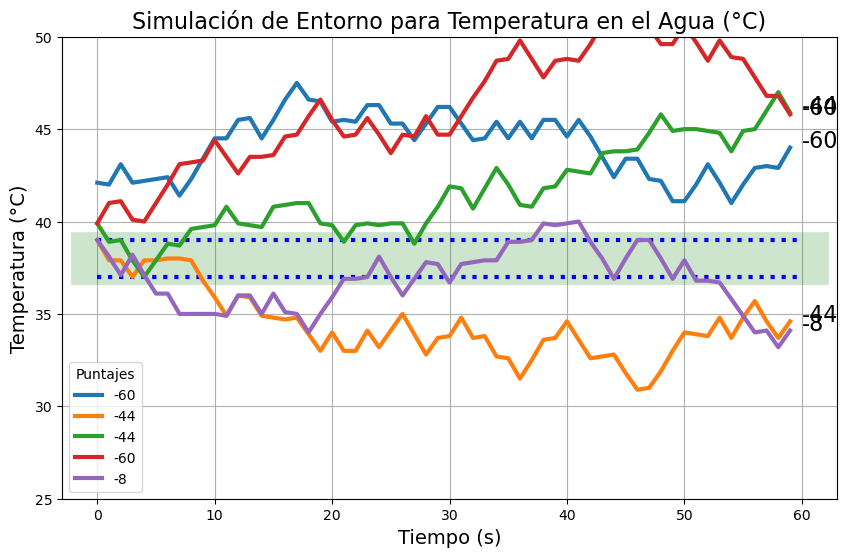

In [95]:
episodes = 5
plt.figure(figsize=(10,6))

# diagrama la franja de control
plt.plot([0,60], [38,38], 'g-', lw=38, alpha=0.2)
plt.plot([0,60], [37,37], 'b:', lw=3)
plt.plot([0,60], [39,39], 'b:', lw=3)

# corre curvas aleatorias de alteración de la temperatura
for episode in range(1, episodes+1):
    state = env.reset()
    done, score, temps = False, 0, []
    
    while not done:
        #env.render()
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        temps.append(n_state)
        score += reward
    plt.plot(temps, lw=3, label=score)
    if temps[-1] < 50:
        plt.text(60,temps[-1],score, fontsize=16)

plt.title('Simulación de Entorno para Temperatura en el Agua (\u00b0C)', fontsize=16)
plt.xlabel('Tiempo (s)', fontsize=14)
plt.ylabel('Temperatura (\u00b0C)', fontsize=14)
plt.ylim(25, 50)
plt.legend(loc='best', title='Puntajes')
plt.grid(True)    
plt.show()

In [97]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [99]:
states = env.observation_space.shape
actions = env.action_space.n
print(states, actions)

(1,) 3


In [101]:
env.observation_space.sample()

array([43.522846], dtype=float32)

In [103]:
def modelo_RL(states, actions):
    model = Sequential()
    model.add(Dense(24, activation='relu', input_shape=states))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [105]:
model = modelo_RL(states, actions)
model.summary()

C:\AnacondaD\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 24)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 24)             │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            75 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 723 (2.82 KB)

 Trainable params: 723 (2.82 KB)

 Non-trainable params: 0 (0.00 B)

# Option: baseline

In [109]:
!pip install shimmy==0.2.1

In [111]:
model = PPO('MlpPolicy', env=env, verbose=1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\AnacondaD\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [137]:
model.learn(total_timesteps=30000)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 60       |
|    ep_rew_mean     | 16.9     |
| time/              |          |
|    fps             | 1758     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 60          |
|    ep_rew_mean          | 22          |
| time/                   |             |
|    fps                  | 1182        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011690861 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.843      |
|    explained_variance   | -0.0157     |
|    learning_rate        | 0.

In [132]:
for t in [20.0, 35.0, 39.0, 45.0]:
    action, _ = model.predict((t,))
    print(action)

2
1
1
0


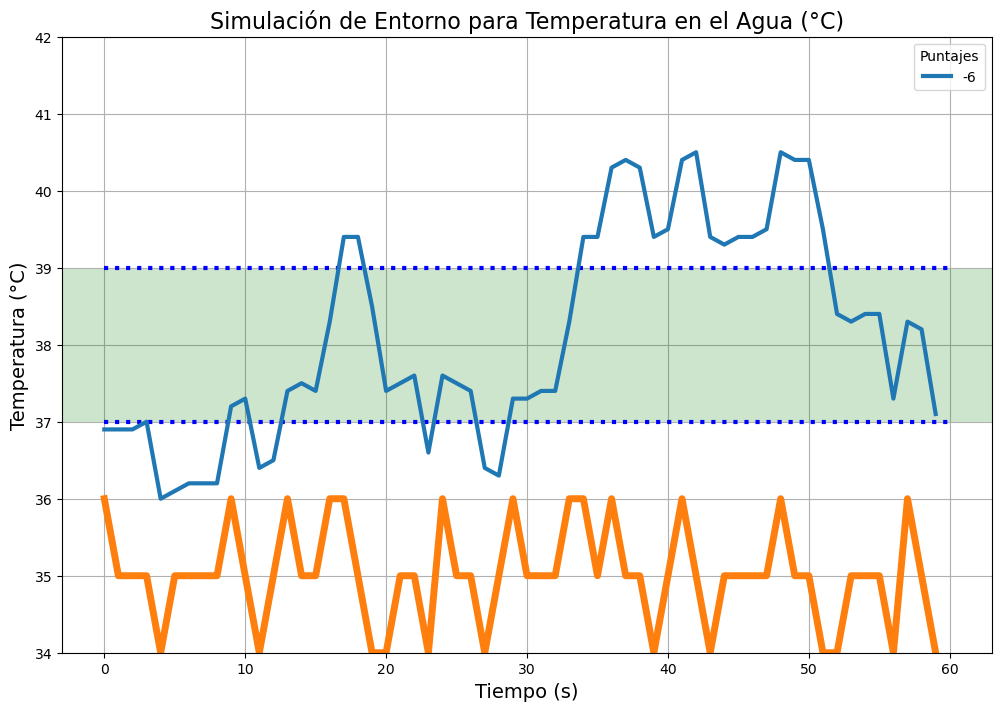

In [129]:
episodes = 1
plt.figure(figsize=(12,8))
plt.plot([0,60], [38,38], 'g-', lw=110, alpha=0.2)
plt.plot([0,60], [37,37], 'b:', lw=3)
plt.plot([0,60], [39,39], 'b:', lw=3)

for episode in range(1, episodes+1):
    obs = env.reset()
    done, score, temps, acts = False, 0, [], []
    
    while not done:
        #env.render()
        action, _ = model.predict([obs])
        obs, reward, done, info = env.step(action)
        temps.append(obs)
        acts.append(action)
        score += reward
    plt.plot(temps, lw=3, label=score)
    plt.plot(np.array(acts)+34, lw=5)
    
plt.title('Simulación de Entorno para Temperatura en el Agua (\u00b0C)', fontsize=16)
plt.xlabel('Tiempo (s)', fontsize=14)
plt.ylabel('Temperatura (\u00b0C)', fontsize=14)
plt.ylim(34, 42)
plt.legend(loc='best', title='Puntajes')
plt.grid(True)    
plt.show()

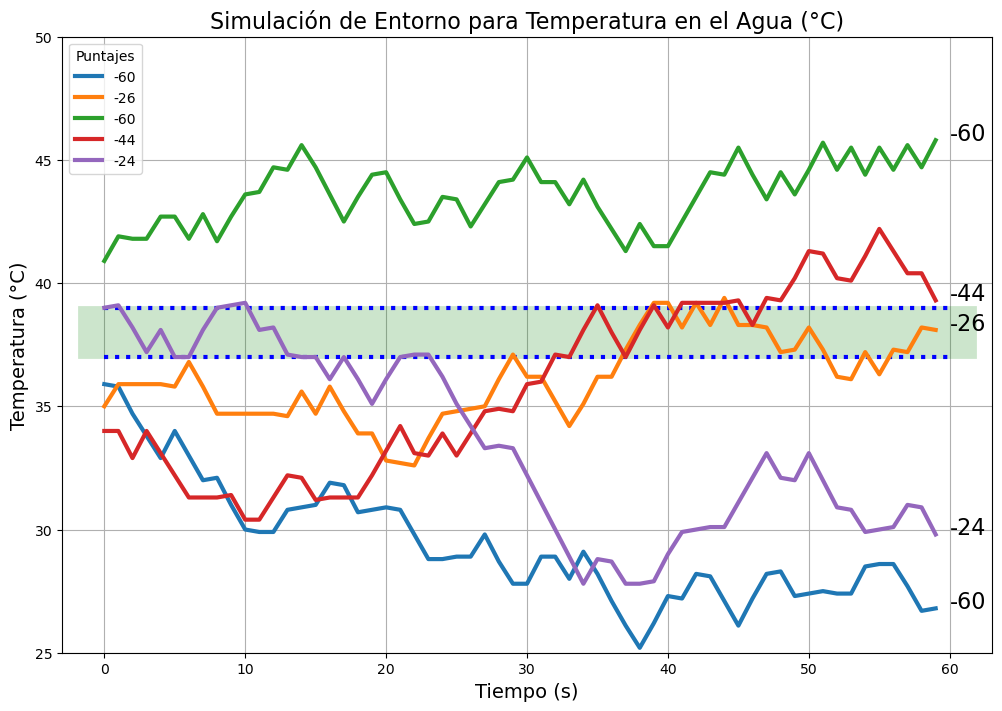

In [79]:
episodes = 5
plt.figure(figsize=(12,8))
plt.plot([0,60], [38,38], 'g-', lw=38, alpha=0.2)
plt.plot([0,60], [37,37], 'b:', lw=3)
plt.plot([0,60], [39,39], 'b:', lw=3)

for episode in range(1, episodes+1):
    state = env.reset()
    done, score, temps = False, 0, []
    
    while not done:
        #env.render()
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        temps.append(n_state)
        score += reward
    plt.plot(temps, lw=3, label=score)
    if temps[-1] < 50:
        plt.text(60,temps[-1],score, fontsize=16)

plt.title('Simulación de Entorno para Temperatura en el Agua (\u00b0C)', fontsize=16)
plt.xlabel('Tiempo (s)', fontsize=14)
plt.ylabel('Temperatura (\u00b0C)', fontsize=14)
plt.ylim(25, 50)
plt.legend(loc='best', title='Puntajes')
plt.grid(True)    
plt.show()